# 1) Data Preparation and import Modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### 1.1) Split - Normalization 

In [2]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Notice how FashionMNIST is also built into PyTorch!
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

#### 1.2) Data Loaders

In [3]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


# 1.3) Data Pre-vizualization

train: 28
val: torch.Size([1, 28, 28])
test: torch.Size([1, 28, 28])
train labels : tensor(2)
val labels : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


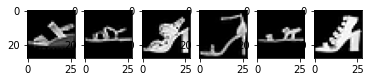

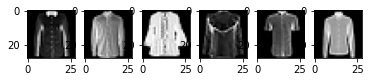

In [4]:
# plot a digit ground truth and autoencoding
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

# View 6 bags
view_fashionmnist(5, 6)    
view_fashionmnist(6, 6)

# fast dataset review 

# Tensor dimentionality vizualization 
print("train:", fashion_mnist_train[0][0].shape[1])
print("val:", fashion_mnist_val[0][0].shape)
print("test:", fashion_mnist_test[0][0].shape)


# labels 
print("train labels :", fashion_mnist_train.dataset.targets[5])
print("val labels :", fashion_mnist_val.dataset.targets.unique())
print("test labels:", fashion_mnist_test.targets.unique())

# 2) Model HyperParameters and definition

In [6]:
# Hint! Create a CNNClassifier class that implements a forward function
from keras.layers import Dropout
from torch.nn.modules.flatten import Flatten

class CNNClassifier_1(nn.Module):
    def __init__(self):
        super(CNNClassifier_1, self).__init__()

        self.pipeline = nn.Sequential(
            
            # Feature learning 
            
            # first convolutional layer 
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            # second convolutional layer 
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            
            
            # Clasification 
            
            # Flaten layer
            nn.Flatten(),
            # first linear layer
            nn.Linear(8*7*7, 64),
            nn.ReLU(),
            # output layer
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.pipeline(x)
    

In [7]:
learning_rate = 0.001
num_epochs = 10
dropout = .25


model = CNNClassifier_1().to(device)


print(model)


CNNClassifier_1(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=392, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


# 3) Train The Model

In [8]:
# training function 
def train_model(model, dataloaders, dataset_sizes,
                criterion, optimizer, scheduler , num_epochs = 25):
    
    # sets initial time stamp (for measuring code time) 
    since = time.time()
    
    # store the best weigths separately
    best_model_wts = copy.deepcopy(model.state_dict()) 

    best_acc = 0.0
    best_epoch = 0 
    
    
    
    phases = ['train','val','test']
    
    # keep track of how loss and acuraccy evolves during training 
   
    training_curves = {}
    for phase in phases: 
        training_curves[phase + '_loss'] = []
        training_curves[phase + '_acc'] = []
        
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in phases:
            # set model in training mode
            
            if phase == 'train':
                model.train() 
        
            else :
            
                # set model to evaluate mode
                model.eval() 
            
            running_loss = 0.0
            running_corrects = 0
        
            # iterate over the inputs and the labels tensors in the data loader
            for inputs, labels in dataloaders[phase]:
        
            
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # reset gradients to 0 
                optimizer.zero_grad()
                
                # forward 
                # enables gradient calculation at train phase 
                with torch.set_grad_enabled(phase == 'train'): 
                    # compute the outputs
                    outputs = model(inputs) 
                    # store the index of the class predicted 
                    _, predictions = torch.max(outputs , 1) 
                    # compute the loss 
                    loss = criterion(outputs,labels) 
                
                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics 
                # acumulate the loss over each iteration 
                running_loss += loss.item() * inputs.size(0)
                # acumulate the acert over each iteration  
                running_corrects += torch.sum(predictions == labels.data)
                
            # updates the learning rate 
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves    

In [9]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_model(model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)



Epoch 1/10
----------
train Loss: 0.7170 Acc: 0.7446
val   Loss: 0.4741 Acc: 0.8261
test  Loss: 0.5018 Acc: 0.8119

Epoch 2/10
----------
train Loss: 0.4325 Acc: 0.8453
val   Loss: 0.3867 Acc: 0.8609
test  Loss: 0.4166 Acc: 0.8501

Epoch 3/10
----------
train Loss: 0.3814 Acc: 0.8638
val   Loss: 0.3570 Acc: 0.8711
test  Loss: 0.3864 Acc: 0.8638

Epoch 4/10
----------
train Loss: 0.3501 Acc: 0.8760
val   Loss: 0.3362 Acc: 0.8785
test  Loss: 0.3643 Acc: 0.8722

Epoch 5/10
----------
train Loss: 0.3268 Acc: 0.8834
val   Loss: 0.3195 Acc: 0.8857
test  Loss: 0.3466 Acc: 0.8770

Epoch 6/10
----------
train Loss: 0.3082 Acc: 0.8892
val   Loss: 0.3051 Acc: 0.8901
test  Loss: 0.3313 Acc: 0.8834

Epoch 7/10
----------
train Loss: 0.2929 Acc: 0.8948
val   Loss: 0.2948 Acc: 0.8934
test  Loss: 0.3196 Acc: 0.8870

Epoch 8/10
----------
train Loss: 0.2802 Acc: 0.8999
val   Loss: 0.2874 Acc: 0.8959
test  Loss: 0.3110 Acc: 0.8893

Epoch 9/10
----------
train Loss: 0.2696 Acc: 0.9041
val   Loss: 0.2811

# 4) Model Metrics 

In [20]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves, title,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']  ):
    
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'{title} - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders,  title ,phase='test' ):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title(title)


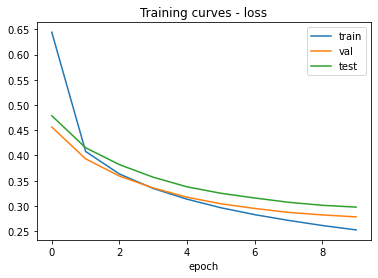

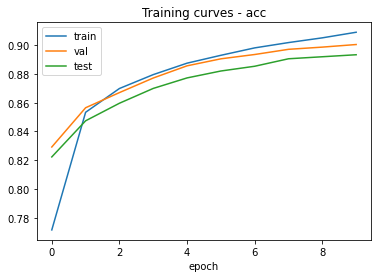

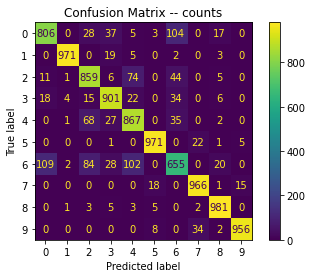

In [11]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'] , title = 'Training curves')

res = plot_cm(model, device, dataloaders, phase='test' , title = 'Confusion Matrix -- counts' )



# Model 2 peformance

In [10]:


# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Notice how FashionMNIST is also built into PyTorch!
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

In [11]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders2 = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes2 = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes2 = {dataset_sizes2}')

dataset_sizes2 = {'train': 45000, 'val': 15000, 'test': 10000}


In [12]:



class CNNClassifier_2(nn.Module):
    def __init__(self, dropout):
        super(CNNClassifier_2, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.pipeline = nn.Sequential(
            
           # Feature learning 
            
            # first convolutional layer 
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size = 2, stride = 2), 
            # second convolutional layer 
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size = 3, stride = 1 ,  padding = 1), 
             
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size = 3, stride = 1 ,  padding = 1), 
             
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            
            # Clasification 
            
            # Flaten layer
            nn.Flatten(),
            # first linear layer
            nn.Linear(8*7*7, 64),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(),
            # output layer
            nn.Linear(64, 10)
        )
        
        
    def forward(self, x):
        return self.pipeline(x)    

 

In [16]:
learning_rate = 0.001
num_epochs = 50
dropout = .25



model_2 = CNNClassifier_2(dropout).to(device)

print(model_2)

CNNClassifier_2(
  (dropout): Dropout(p=0.25, inplace=False)
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (15): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(8, 8, kernel_s

In [17]:
# training function 
def train_model(model, dataloaders2, dataset_sizes2,
                criterion, optimizer, scheduler , num_epochs = 25):
    
    # sets initial time stamp (for measuring code time) 
    since = time.time()
    
    # store the best weigths separately
    best_model_wts = copy.deepcopy(model.state_dict()) 

    best_acc = 0.0
    best_epoch = 0 
    
    
    
    phases = ['train','val','test']
    
    # keep track of how loss and acuraccy evolves during training 
   
    training_curves = {}
    for phase in phases: 
        training_curves[phase + '_loss'] = []
        training_curves[phase + '_acc'] = []
        
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in phases:
            # set model in training mode
            
            if phase == 'train':
                model.train() 
        
            else :
            
                # set model to evaluate mode
                model.eval() 
            
            running_loss = 0.0
            running_corrects = 0
        
            # iterate over the inputs and the labels tensors in the data loader
            for inputs, labels in dataloaders2[phase]:
        
            
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # reset gradients to 0 
                optimizer.zero_grad()
                
                # forward 
                # enables gradient calculation at train phase 
                with torch.set_grad_enabled(phase == 'train'): 
                    # compute the outputs
                    outputs = model(inputs) 
                    # store the index of the class predicted 
                    _, predictions = torch.max(outputs , 1) 
                    # compute the loss 
                    loss = criterion(outputs,labels) 
                
                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics 
                # acumulate the loss over each iteration 
                running_loss += loss.item() * inputs.size(0)
                # acumulate the acert over each iteration  
                running_corrects += torch.sum(predictions == labels.data)
                
            # updates the learning rate 
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes2[phase]
            epoch_acc = running_corrects.double() / dataset_sizes2[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves   

In [18]:
# model 2 
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


model_2, training_curves_2 = train_model(model_2, dataloaders2, dataset_sizes2, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 1.3078 Acc: 0.4926
val   Loss: 0.6727 Acc: 0.7505
test  Loss: 0.6914 Acc: 0.7435

Epoch 2/50
----------
train Loss: 0.7994 Acc: 0.7020
val   Loss: 0.5588 Acc: 0.7828
test  Loss: 0.5740 Acc: 0.7749

Epoch 3/50
----------
train Loss: 0.7155 Acc: 0.7375
val   Loss: 0.5322 Acc: 0.7941
test  Loss: 0.5474 Acc: 0.7882

Epoch 4/50
----------
train Loss: 0.6593 Acc: 0.7558
val   Loss: 0.4935 Acc: 0.8169
test  Loss: 0.5087 Acc: 0.8074

Epoch 5/50
----------
train Loss: 0.6278 Acc: 0.7651
val   Loss: 0.4729 Acc: 0.8295
test  Loss: 0.4889 Acc: 0.8202

Epoch 6/50
----------
train Loss: 0.6024 Acc: 0.7761
val   Loss: 0.4521 Acc: 0.8377
test  Loss: 0.4706 Acc: 0.8315

Epoch 7/50
----------
train Loss: 0.5841 Acc: 0.7858
val   Loss: 0.4399 Acc: 0.8430
test  Loss: 0.4613 Acc: 0.8345

Epoch 8/50
----------
train Loss: 0.5648 Acc: 0.7920
val   Loss: 0.4280 Acc: 0.8467
test  Loss: 0.4546 Acc: 0.8353

Epoch 9/50
----------
train Loss: 0.5493 Acc: 0.7988
val   Loss: 0.4072

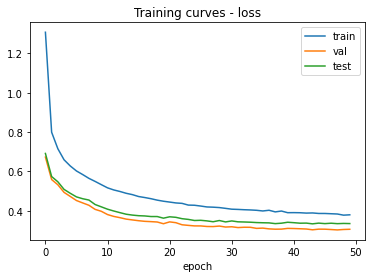

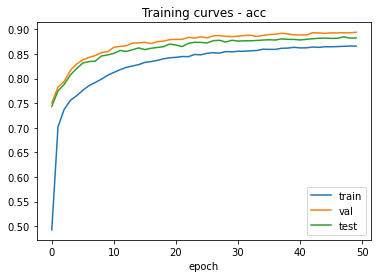

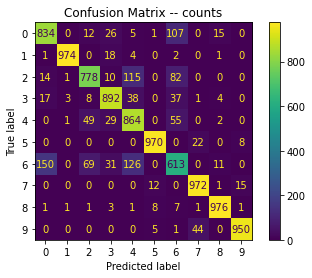

In [21]:
plot_training_curves(training_curves_2 , phases=['train', 'val', 'test'] 
                     , title = 'Training curves')

res = plot_cm(model_2 , device, dataloaders2, phase='test' 
              , title = 'Confusion Matrix -- counts' )


# CONCLUSION

Class 6 and 0 are the most often missclasified between each other , they describle similar objects like t shirts and shirts.

Dropout made the performance a bit worse , but i also added more convolutional layer that may affect the performance in some way. However the second model generalizes better than the first model, respect to their training sets. 



In [ ]:
model.